In [2]:
import pandas as pd
import os
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


Import data to DF

In [3]:
train_data = []
test_data = []

# Hardcoded pad naar de hoofdmap
base_path = r"/Users/hugo/AI-Tutor/Codebase/DataMiningP2/raw_files/negative_polarity"

# Loop door de klassen (deceptive en truthful)
for class_folder in os.listdir(base_path):
    class_path = os.path.join(base_path, class_folder)

    if os.path.isdir(class_path):
        subfolders = os.listdir(class_path)
        # pak de eerste 4 folder als train set
        for subfolder in subfolders[:-1]:
            subfolder_path = os.path.join(class_path, subfolder)
            for file_name in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file_name)
                with open(file_path, 'r', encoding='utf-8') as file:
                    # lowercase alle woorden
                    content = file.read().lower()
                    # Verwijder engelse stopwoorden
                    content = ' '.join([word for word in content.split() if word not in ENGLISH_STOP_WORDS])

                    train_data.append((content, class_folder))

        # Pak de laatste folder als testset
        test_subfolder = subfolders[-1]
        test_subfolder_path = os.path.join(class_path, test_subfolder)
        for file_name in os.listdir(test_subfolder_path):
            file_path = os.path.join(test_subfolder_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                # lowercase alle woorden
                content = file.read().lower()

                # Verwijder engelse stopwoorden
                content = ' '.join([word for word in content.split() if word not in ENGLISH_STOP_WORDS])

                test_data.append((content, class_folder))

# Zet de gegevens om in een DataFrame
train_df = pd.DataFrame(train_data, columns=['text', 'label'])
test_df = pd.DataFrame(test_data, columns=['text', 'label'])


EDA

In [4]:
print(train_df.head())
print(test_df.head())
print(train_df.info())
print(test_df.info())
print(train_df.describe())
print(test_df.describe())
print(train_df['label'].value_counts())
print(test_df['label'].value_counts())


                                                text                 label
0  talbott hotel claims chicago's premiere small ...  deceptive_from_MTurk
1  selected talbott recent family vacation chicag...  deceptive_from_MTurk
2  recently stayed affinia hotel chicago, worst e...  deceptive_from_MTurk
3  husband stayed hard rock hotel chicago months ...  deceptive_from_MTurk
4  stayed hard rock hotel chicago recently conven...  deceptive_from_MTurk
                                                text                 label
0  husband stayed sofitel chicago water tower nig...  deceptive_from_MTurk
1  staying sofitel pleasurable experiences chicag...  deceptive_from_MTurk
2  stayed sofitel husband weekend staying again! ...  deceptive_from_MTurk
3  stayed sofitel chicago water tower hotel coupl...  deceptive_from_MTurk
4  arriving sofitel chicago water tower hotel gre...  deceptive_from_MTurk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 2 column

Split train en test variables

In [5]:
X_train = train_df['text']
y_train = train_df['label']
X_test = test_df['text']
y_test = test_df['label']

--------------------------------------------------------------

Multionomial Bayes

In [6]:

# Import chi^2 test
from sklearn.feature_selection import SelectKBest, chi2

# Feature selectie
feature_selector = SelectKBest(chi2, k=1000)  # Select top 1000 features

# Maak pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_selection', feature_selector),
    ('classifier', MultinomialNB())
])

# Parameter grid
param_grid = {
    'vectorizer__max_features': [2000, 3000, 4000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'feature_selection__k': [500, 1000, 1500],
    'classifier__alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
}
#GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Beste estimator
best_model = grid_search.best_estimator_

# Grbuik die voor prediction met test data
y_pred = best_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Multinomial_Naive_Bayes ({ngram_type}): ")
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Multinomial_Naive_Bayes ({ngram_type}): 
Accuracy: 0.775
Precision: 0.7756892230576441
Recall: 0.775
F1 Score: 0.774859287054409


--------------------------------------------------------------

Logistic Regression

In [7]:
pipeline_logreg = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_selection', SelectKBest(chi2, k=1000)),
    ('classifier', LogisticRegression(penalty='l1', max_iter=10000))
])

param_grid_Log = {
    'vectorizer__max_features': [2000, 3000, 4000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['saga']
}

# GridSearchCV
grid_search_logreg = GridSearchCV(estimator=pipeline_logreg,
                                  param_grid=param_grid_Log,
                                  cv=5,
                                  scoring='accuracy')

# Fit op train data
grid_search_logreg.fit(X_train, y_train)

# Beste estimator
best_model_logreg = grid_search_logreg.best_estimator_

# Prediction
y_pred_logreg = best_model_logreg.predict(X_test)

# Metrics
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

#print resultaten
accuracy_log = accuracy_score(y_test, y_pred)
precision_log = precision_score(y_test, y_pred, average='weighted')
recall_log = recall_score(y_test, y_pred, average='weighted')
f1_log = f1_score(y_test, y_pred, average='weighted')
ngram_type = "Unigrams" if grid_search_logreg.best_params_['vectorizer__ngram_range'] == (1, 1) else "Unigrams and Bigrams"


In [8]:
print(f"Logistic Regression ({ngram_type}): ")
print(f'Accuracy: {accuracy_log}')
print(f'Precision: {precision_log}')
print(f'Recall: {recall_log}')
print(f'F1 Score: {f1_log}')

Logistic Regression (Unigrams and Bigrams): 
Accuracy: 0.775
Precision: 0.7756892230576441
Recall: 0.775
F1 Score: 0.774859287054409


--------------------------------------------------------------

Decision Tree

In [9]:
# Decision Tree met pipeline
pipeline_dt = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', DecisionTreeClassifier())
])

tuned_param_dt = {
    'vectorizer__max_features': [2000, 3000, 4000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__max_depth': [3, 5, 7, None],
    'classifier__ccp_alpha': [0.0, 0.001, 0.01]
}

# GridSearchCV
grid_search_dt = GridSearchCV(
    estimator=pipeline_dt,
    param_grid=tuned_param_dt,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# Fit op train data
grid_search_dt.fit(X_train, y_train)

# Beste estimator
best_model_dt = grid_search_dt.best_estimator_
ngram_type = "Unigrams" if grid_search_dt.best_params_['vectorizer__ngram_range'] == (1, 1) else "Unigrams and Bigrams"
# Prediction
y_pred_dt = best_model_dt.predict(X_test)

# Metrics
accuracy_tree = accuracy_score(y_test, y_pred_dt)
precision_tree = precision_score(y_test, y_pred_dt, average='weighted')
recall_tree = recall_score(y_test, y_pred_dt, average='weighted')
f1_tree = f1_score(y_test, y_pred_dt, average='weighted')

print(f"Decision Tree ({ngram_type}): ")
print(f'Accuracy: {accuracy_tree}')
print(f'Precision: {precision_tree}')
print(f'Recall: {recall_tree}')
print(f'F1 Score: {f1_tree}')


Decision Tree (Unigrams and Bigrams): 
Accuracy: 0.71875
Precision: 0.7190580503833516
Recall: 0.71875
F1 Score: 0.7186510882732211


--------------------------------------------------------------

Random Forests

In [10]:
from sklearn.model_selection import ParameterGrid

pipeline_rf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', RandomForestClassifier(oob_score=True))
])

param_grid_rf = {
    'vectorizer__max_features': [2000, 3000, 4000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7, None],
    'classifier__criterion': ['entropy', 'gini'],
}

best_oob_score = 0
best_params = None
best_model = None

# Iterate through parameter combinations
for params in ParameterGrid(param_grid_rf):
    # Set parameters
    pipeline_rf.set_params(**params)

    # Fit the model
    pipeline_rf.fit(X_train, y_train)

    # Get OOB score
    oob_score = pipeline_rf.named_steps['classifier'].oob_score_

    # Update best model if OOB score improves
    if oob_score > best_oob_score:
        best_oob_score = oob_score
        best_params = params
        best_model = pipeline_rf

# Use the best model for predictions
y_pred_rf = best_model.predict(X_test)

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

ngram_type = "Unigrams" if best_params['vectorizer__ngram_range'] == (1, 1) else "Unigrams and Bigrams"

print(f"Random Forests ({ngram_type}): ")
print(f'Best OOB Score: {best_oob_score}')
print(f'Best Parameters: {best_params}')
print(f'Test Accuracy: {accuracy_rf}')
print(f'Test Precision: {precision_rf}')
print(f'Test Recall: {recall_rf}')
print(f'Test F1 Score: {f1_rf}')

Random Forests (Unigrams and Bigrams): 
Best OOB Score: 0.8640625
Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__n_estimators': 300, 'vectorizer__max_features': 3000, 'vectorizer__ngram_range': (1, 2)}
Test Accuracy: 0.80625
Test Precision: 0.806297859040475
Test Recall: 0.80625
Test F1 Score: 0.8062424313449743


important features uit Randomforest halen

Top 20 Most Important Features:
              feature  importance
617           chicago    0.028529
1733    hotel chicago    0.010405
2144         location    0.009680
3268          smelled    0.006863
2828         recently    0.006666
3266            smell    0.006211
2316       millennium    0.005548
2829  recently stayed    0.005221
2213           luxury    0.005108
1546            great    0.005007
683           cleaned    0.004790
1364          finally    0.004727
3891          website    0.004650
3703           turned    0.004591
628     chicago hotel    0.004528
1713            hotel    0.004298
3351             star    0.004201
2106             like    0.003917
1165         elevator    0.003783
1166        elevators    0.003745


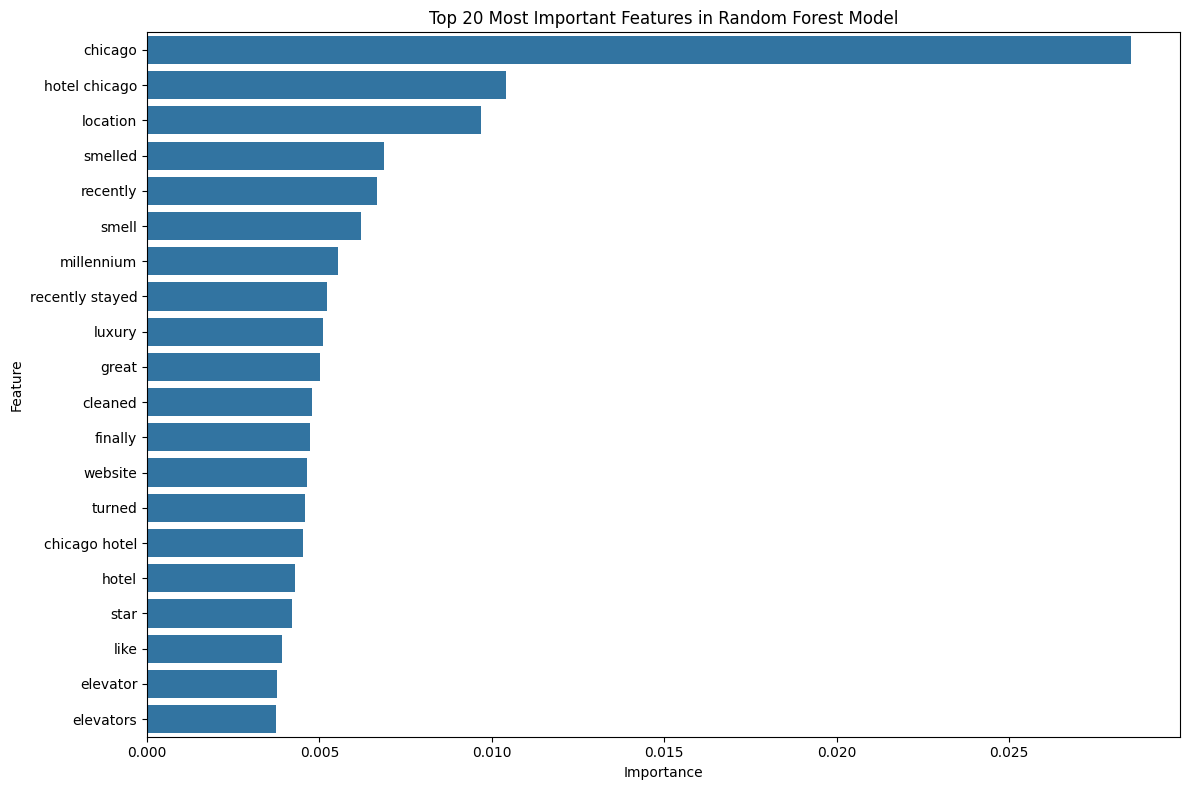

In [11]:
# Extract feature importances from the best Random Forest model
feature_importances = best_model.named_steps['classifier'].feature_importances_

# Get feature names from the vectorizer
feature_names = best_model.named_steps['vectorizer'].get_feature_names_out()

# Create a DataFrame with feature names and their importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values('importance', ascending=False)

# Display the top 20 most important features
print("Top 20 Most Important Features:")
print(importance_df.head(20))
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize the top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(20))
plt.title('Top 20 Most Important Features in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [12]:
from statsmodels.stats.contingency_tables import mcnemar

def perform_mcnemar_test(y_true, pred1, pred2, model1_name, model2_name):
    # Create contingency table
    table = [[0, 0], [0, 0]]
    for i in range(len(y_true)):
        if pred1[i] == y_true[i] and pred2[i] == y_true[i]:
            table[0][0] += 1
        elif pred1[i] == y_true[i] and pred2[i] != y_true[i]:
            table[0][1] += 1
        elif pred1[i] != y_true[i] and pred2[i] == y_true[i]:
            table[1][0] += 1
        else:
            table[1][1] += 1

    # Perform McNemar test
    result = mcnemar(table, exact=True)

    print(f"\nMcNemar's test results for {model1_name} vs {model2_name}")
    print(f"Statistic: {result.statistic:.4f}")
    print(f"P-value: {result.pvalue:.4f}")
    print("Null hypothesis: the two models have the same error rate")
    print(f"Reject null hypothesis: {result.pvalue < 0.05}")

# Perform all pairwise comparisons
model_predictions = {
    'Naive Bayes': y_pred,
    'Logistic Regression': y_pred_logreg,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf
}

# Compare all pairs of models
models = list(model_predictions.keys())
for i in range(len(models)):
    for j in range(i + 1, len(models)):
        perform_mcnemar_test(
            y_test,
            model_predictions[models[i]],
            model_predictions[models[j]],
            models[i],
            models[j]
        )


McNemar's test results for Naive Bayes vs Logistic Regression
Statistic: 7.0000
P-value: 0.0639
Null hypothesis: the two models have the same error rate
Reject null hypothesis: False

McNemar's test results for Naive Bayes vs Decision Tree
Statistic: 18.0000
P-value: 0.2327
Null hypothesis: the two models have the same error rate
Reject null hypothesis: False

McNemar's test results for Naive Bayes vs Random Forest
Statistic: 9.0000
P-value: 0.4049
Null hypothesis: the two models have the same error rate
Reject null hypothesis: False

McNemar's test results for Logistic Regression vs Decision Tree
Statistic: 9.0000
P-value: 0.0026
Null hypothesis: the two models have the same error rate
Reject null hypothesis: True

McNemar's test results for Logistic Regression vs Random Forest
Statistic: 8.0000
P-value: 0.3833
Null hypothesis: the two models have the same error rate
Reject null hypothesis: False

McNemar's test results for Decision Tree vs Random Forest
Statistic: 11.0000
P-value: 0

In [14]:
# Store results from each model with their feature type
model_results = {
    'Naive Bayes_unigram': y_pred if grid_search.best_params_['vectorizer__ngram_range'] == (1, 1) else None,
    'Naive Bayes_bigram': y_pred if grid_search.best_params_['vectorizer__ngram_range'] == (1, 2) else None,
    'Logistic_unigram': y_pred_logreg if grid_search_logreg.best_params_['vectorizer__ngram_range'] == (1, 1) else None,
    'Logistic_bigram': y_pred_logreg if grid_search_logreg.best_params_['vectorizer__ngram_range'] == (1, 2) else None,
    'RandomForest_unigram': y_pred_rf if best_params['vectorizer__ngram_range'] == (1, 1) else None,
    'RandomForest_bigram': y_pred_rf if best_params['vectorizer__ngram_range'] == (1, 2) else None
}

# Remove None values
model_results = {k: v for k, v in model_results.items() if v is not None}

print("1. Comparing Naive Bayes vs Logistic Regression:")
perform_mcnemar_test(
    y_test,
    y_pred,  # Naive Bayes predictions
    y_pred_logreg,  # Logistic Regression predictions
    'Naive Bayes',
    'Logistic Regression'
)

print("\n2. Comparing Random Forest vs Linear Models:")
# Compare RF with Naive Bayes
perform_mcnemar_test(
    y_test,
    y_pred_rf,  # Random Forest predictions
    y_pred,  # Naive Bayes predictions
    'Random Forest',
    'Naive Bayes'
)
# Compare RF with Logistic Regression
perform_mcnemar_test(
    y_test,
    y_pred_rf,  # Random Forest predictions
    y_pred_logreg,  # Logistic Regression predictions
    'Random Forest',
    'Logistic Regression'
)

print("\n3. Comparing Unigram vs Bigram performance:")
# Print accuracy scores for each model with their feature type
for model_name, predictions in model_results.items():
    acc = accuracy_score(y_test, predictions)
    print(f"{model_name}: Accuracy = {acc:.4f}")

1. Comparing Naive Bayes vs Logistic Regression:

McNemar's test results for Naive Bayes vs Logistic Regression
Statistic: 7.0000
P-value: 0.0639
Null hypothesis: the two models have the same error rate
Reject null hypothesis: False

2. Comparing Random Forest vs Linear Models:

McNemar's test results for Random Forest vs Naive Bayes
Statistic: 9.0000
P-value: 0.4049
Null hypothesis: the two models have the same error rate
Reject null hypothesis: False

McNemar's test results for Random Forest vs Logistic Regression
Statistic: 8.0000
P-value: 0.3833
Null hypothesis: the two models have the same error rate
Reject null hypothesis: False

3. Comparing Unigram vs Bigram performance:
Naive Bayes_bigram: Accuracy = 0.7750
Logistic_bigram: Accuracy = 0.8375
RandomForest_bigram: Accuracy = 0.8063
